In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
MEDford_df = pd.read_csv('MEdford_US_Data_2015-2018_EDITED.csv') 
MEDford_df = MEDford_df.dropna()
MEDford_df

Year  Month  Day  Hour  Minute  GHI  Clearsky GHI  Cloud Type  \
0      2015      1    1     0      30    0             0           0   
1      2015      1    1     1      30    0             0           0   
2      2015      1    1     2      30    0             0           0   
3      2015      1    1     3      30    0             0           0   
4      2015      1    1     4      30    0             0           0   
...     ...    ...  ...   ...     ...  ...           ...         ...   
35035  2018     12   31    19      30    0             0           7   
35036  2018     12   31    20      30    0             0           7   
35037  2018     12   31    21      30    0             0           7   
35038  2018     12   31    22      30    0             0           4   
35039  2018     12   31    23      30    0             0           7   

       Wind Speed  Relative Humidity  Temperature  Pressure  
0             0.4              85.18         -1.0       970  
1             0.4              83.54         -1.0       970  
2             0.4              82.07         -1.0       970  
3             0.4              80.75         -1.0       970  
4             0.4              79.63         -2.0       970  
...           ...                ...          ...       ...  
35035         0.5              81.77          7.9       967  
35036         0.5              81.06          7.9       968  
35037         0.6              79.58          8.2       969  
35038         0.6              78.96          8.4       969  
35039         0.7              79.82          8.2       969  

[35040 rows x 12 columns]

In [3]:
MEDford_df_new = MEDford_df.copy()

MEDford_df_new['DateTime'] = MEDford_df[['Year', 'Month', 'Day', 'Hour']].apply(lambda s : datetime.datetime(*s),axis = 1)
MEDford_df_new = MEDford_df_new.drop(columns = ['Year','Minute'])
MEDford_df_new['DateTime'] = pd.to_datetime(MEDford_df_new['DateTime']) 
MEDford_df_new.set_index(['DateTime'], drop=True, inplace=True)
MEDford_df_new

Month  Day  Hour  GHI  Clearsky GHI  Cloud Type  \
DateTime                                                               
2015-01-01 00:00:00      1    1     0    0             0           0   
2015-01-01 01:00:00      1    1     1    0             0           0   
2015-01-01 02:00:00      1    1     2    0             0           0   
2015-01-01 03:00:00      1    1     3    0             0           0   
2015-01-01 04:00:00      1    1     4    0             0           0   
...                    ...  ...   ...  ...           ...         ...   
2018-12-31 19:00:00     12   31    19    0             0           7   
2018-12-31 20:00:00     12   31    20    0             0           7   
2018-12-31 21:00:00     12   31    21    0             0           7   
2018-12-31 22:00:00     12   31    22    0             0           4   
2018-12-31 23:00:00     12   31    23    0             0           7   

                     Wind Speed  Relative Humidity  Temperature  Pressure  
DateTime                                                                   
2015-01-01 00:00:00         0.4              85.18         -1.0       970  
2015-01-01 01:00:00         0.4              83.54         -1.0       970  
2015-01-01 02:00:00         0.4              82.07         -1.0       970  
2015-01-01 03:00:00         0.4              80.75         -1.0       970  
2015-01-01 04:00:00         0.4              79.63         -2.0       970  
...                         ...                ...          ...       ...  
2018-12-31 19:00:00         0.5              81.77          7.9       967  
2018-12-31 20:00:00         0.5              81.06          7.9       968  
2018-12-31 21:00:00         0.6              79.58          8.2       969  
2018-12-31 22:00:00         0.6              78.96          8.4       969  
2018-12-31 23:00:00         0.7              79.82          8.2       969  

[35040 rows x 10 columns]

Text(0, 0.5, 'GHI ($w/m^2$)')

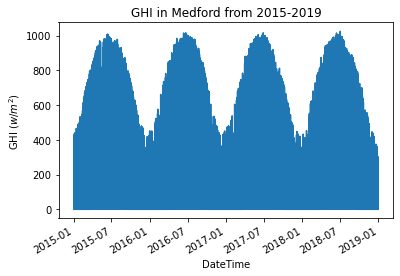

In [4]:
GHI = MEDford_df_new['GHI']
GHI.plot()
plt.title('GHI in Medford from 2015-2019')
plt.ylabel('GHI ($w/m^2$)')

In [5]:
def df_to_X_y_24(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(0, df.shape[0]-window_size-24):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size+24,3]
        y.append(label)
    return np.array(X), np.array(y)

In [6]:
window_size = 24
X,y = df_to_X_y_24(MEDford_df_new, 24)
m,n = X.shape[::3]
X = np.rollaxis(X,3,1).reshape(m,-1,n)
X.shape

(34992, 24, 10)

In [7]:
X_train, X_test, Y_train, Y_test = X[:26244],X[26244:], y[:26244], y[26244:] # Testing: from 30/12/2017 - 31/ 12/ 2018
print('Shape of X_train set:',X_train.shape) 
print('Shape of Y_train set:',Y_train.shape)
print('Shape of X_test set:',X_test.shape)
print('Shape of Y_test set:',Y_test.shape)

Shape of X_train set: (26244, 24, 10)
Shape of Y_train set: (26244,)
Shape of X_test set: (8748, 24, 10)
Shape of Y_test set: (8748,)


In [8]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100)               33600     
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 34,621
Trainable params: 34,621
Non-trainable params: 0
_________________________________________________________________


In [17]:
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=4)
kf.get_n_splits(X_train)
r2score= 0
r2scoretest = 0
for train_index, Validate_index in kf.split(X_train):
    print("TRAIN:", train_index, "TEST:", Validate_index)
    X_Crosstrain, X_Validate = X_train[train_index], X_train[Validate_index]
    y_Crosstrain, y_Validate = Y_train[train_index], Y_train[Validate_index]
    model2 = Sequential()
    model2.add(InputLayer((24,10)))
    model2.add(GRU(10))
    model2.add(Dense(10,'relu'))
    model2.add(Dense(1,'linear'))
    cp = ModelCheckpoint('model2/',save_best_only =True)
    model2.compile(loss = MeanSquaredError() , optimizer = Adam(learning_rate = 0.0001), metrics = RootMeanSquaredError()) 
    model2.fit(X_Crosstrain,y_Crosstrain, epochs = 30, callbacks = [cp])
    
    train_predictions = model2.predict(X_Crosstrain).flatten()
    train_results = pd.DataFrame(data = {'Train prediction':train_predictions,'Actual':y_Crosstrain })
    test_predictions = model2.predict(X_Validate).flatten()
    test_results = pd.DataFrame(data = {'Test prediction':test_predictions,'Actual':y_Validate })

    r2score += r2_score(y_Crosstrain, train_results['Train prediction'] )
    r2scoretest += r2_score(test_results['Actual'], test_results['Test prediction'])

print('Training score:', r2score/4)
print('Testing score:', r2scoretest/4)




TRAIN: [ 6561  6562  6563 ... 26241 26242 26243] TEST: [   0    1    2 ... 6558 6559 6560]
Epoch 1/30
616/616 [==============================] - 8s 10ms/step - loss: 102544.2188 - root_mean_squared_error: 320.2253
Epoch 2/30
616/616 [==============================] - 6s 9ms/step - loss: 101499.2188 - root_mean_squared_error: 318.5894
Epoch 3/30
616/616 [==============================] - 6s 9ms/step - loss: 100282.2578 - root_mean_squared_error: 316.6737
Epoch 4/30
616/616 [==============================] - 5s 9ms/step - loss: 99101.9531 - root_mean_squared_error: 314.8046
Epoch 5/30
616/616 [==============================] - 5s 9ms/step - loss: 97797.7266 - root_mean_squared_error: 312.7263
Epoch 6/30
616/616 [==============================] - 5s 9ms/step - loss: 96387.1172 - root_mean_squared_error: 310.4627
Epoch 7/30
616/616 [==============================] - 5s 9ms/step - loss: 94890.8047 - root_mean_squared_error: 308.0435
Epoch 8/30
616/616 [==============================] - 6s 9

616/616 [==============================] - 6s 9ms/step - loss: 66495.2656 - root_mean_squared_error: 257.8668
Epoch 28/30
616/616 [==============================] - 5s 9ms/step - loss: 65785.0391 - root_mean_squared_error: 256.4859
Epoch 29/30
616/616 [==============================] - 5s 9ms/step - loss: 65138.6250 - root_mean_squared_error: 255.2227
Epoch 30/30
616/616 [==============================] - 5s 9ms/step - loss: 64567.3555 - root_mean_squared_error: 254.1011
TRAIN: [    0     1     2 ... 26241 26242 26243] TEST: [ 6561  6562  6563 ... 13119 13120 13121]
Epoch 1/30
616/616 [==============================] - 7s 9ms/step - loss: 117664.0938 - root_mean_squared_error: 343.0220
Epoch 2/30
616/616 [==============================] - 5s 9ms/step - loss: 117016.2188 - root_mean_squared_error: 342.0763
Epoch 3/30
616/616 [==============================] - 5s 9ms/step - loss: 116347.8203 - root_mean_squared_error: 341.0980
Epoch 4/30
616/616 [==============================] - 5s 9ms/

616/616 [==============================] - 5s 9ms/step - loss: 89562.8516 - root_mean_squared_error: 299.2705
Epoch 25/30
616/616 [==============================] - 5s 9ms/step - loss: 88404.5781 - root_mean_squared_error: 297.3291
Epoch 26/30
616/616 [==============================] - 6s 10ms/step - loss: 87311.4375 - root_mean_squared_error: 295.4851
Epoch 27/30
616/616 [==============================] - 5s 9ms/step - loss: 86292.9922 - root_mean_squared_error: 293.7567
Epoch 28/30
616/616 [==============================] - 5s 9ms/step - loss: 85358.0078 - root_mean_squared_error: 292.1609
Epoch 29/30
616/616 [==============================] - 5s 9ms/step - loss: 84500.9297 - root_mean_squared_error: 290.6904
Epoch 30/30
616/616 [==============================] - 5s 9ms/step - loss: 83726.5625 - root_mean_squared_error: 289.3554
TRAIN: [    0     1     2 ... 26241 26242 26243] TEST: [13122 13123 13124 ... 19680 19681 19682]
Epoch 1/30
616/616 [==============================] - 7s 9ms

616/616 [==============================] - 5s 9ms/step - loss: 91482.8828 - root_mean_squared_error: 302.4614
Epoch 21/30
616/616 [==============================] - 5s 9ms/step - loss: 90055.9453 - root_mean_squared_error: 300.0932
Epoch 22/30
616/616 [==============================] - 5s 9ms/step - loss: 88716.5938 - root_mean_squared_error: 297.8533
Epoch 23/30
616/616 [==============================] - 5s 9ms/step - loss: 87478.1719 - root_mean_squared_error: 295.7671
Epoch 24/30
616/616 [==============================] - 5s 9ms/step - loss: 86352.2109 - root_mean_squared_error: 293.8575
Epoch 25/30
616/616 [==============================] - 5s 9ms/step - loss: 85336.7031 - root_mean_squared_error: 292.1245
Epoch 26/30
616/616 [==============================] - 5s 9ms/step - loss: 84435.4531 - root_mean_squared_error: 290.5778
Epoch 27/30
616/616 [==============================] - 5s 9ms/step - loss: 83654.1328 - root_mean_squared_error: 289.2303
Epoch 28/30
616/616 [===============

616/616 [==============================] - 5s 9ms/step - loss: 88486.1406 - root_mean_squared_error: 297.4662
Epoch 18/30
616/616 [==============================] - 5s 9ms/step - loss: 87229.7109 - root_mean_squared_error: 295.3468
Epoch 19/30
616/616 [==============================] - 5s 9ms/step - loss: 85994.7578 - root_mean_squared_error: 293.2486
Epoch 20/30
616/616 [==============================] - 5s 9ms/step - loss: 84785.2891 - root_mean_squared_error: 291.1791
Epoch 21/30
616/616 [==============================] - 5s 8ms/step - loss: 83614.5703 - root_mean_squared_error: 289.1618
Epoch 22/30
616/616 [==============================] - 5s 8ms/step - loss: 82478.0781 - root_mean_squared_error: 287.1900
Epoch 23/30
616/616 [==============================] - 5s 8ms/step - loss: 81399.7188 - root_mean_squared_error: 285.3064
Epoch 24/30
616/616 [==============================] - 5s 8ms/step - loss: 80380.1250 - root_mean_squared_error: 283.5139
Epoch 25/30
616/616 [===============

In [18]:
kf = KFold(n_splits=4)
kf.get_n_splits(X_train)
r2score= 0
r2scoretest = 0
for train_index, Validate_index in kf.split(X_train):
    print("TRAIN:", train_index, "TEST:", Validate_index)
    X_Crosstrain, X_Validate = X_train[train_index], X_train[Validate_index]
    y_Crosstrain, y_Validate = Y_train[train_index], Y_train[Validate_index]
    model2 = Sequential()
    model2.add(InputLayer((24,10)))
    model2.add(GRU(10))
    model2.add(Dense(10,'relu'))
    model2.add(Dense(1,'linear'))
    cp = ModelCheckpoint('model2/',save_best_only =True)
    model2.compile(loss = MeanSquaredError() , optimizer = Adam(learning_rate = 0.0001), metrics = RootMeanSquaredError()) 
    model2.fit(X_Crosstrain,y_Crosstrain, epochs = 30, callbacks = [cp])
    
    train_predictions = model2.predict(X_Crosstrain).flatten()
    train_results = pd.DataFrame(data = {'Train prediction':train_predictions,'Actual':y_Crosstrain })
    test_predictions = model2.predict(X_Validate).flatten()
    test_results = pd.DataFrame(data = {'Test prediction':test_predictions,'Actual':y_Validate })

    r2score += r2_score(y_Crosstrain, train_results['Train prediction'] )
    r2scoretest += r2_score(test_results['Actual'], test_results['Test prediction'])

print('Training score:', r2score/4)
print('Testing score:', r2scoretest/4)




TRAIN: [ 6561  6562  6563 ... 26241 26242 26243] TEST: [   0    1    2 ... 6558 6559 6560]
Epoch 1/30
616/616 [==============================] - 7s 9ms/step - loss: 102163.7578 - root_mean_squared_error: 319.6306
Epoch 2/30
616/616 [==============================] - 5s 8ms/step - loss: 101548.1562 - root_mean_squared_error: 318.6662
Epoch 3/30
616/616 [==============================] - 5s 8ms/step - loss: 100715.0781 - root_mean_squared_error: 317.3564
Epoch 4/30
616/616 [==============================] - 5s 8ms/step - loss: 99689.2656 - root_mean_squared_error: 315.7361
Epoch 5/30
616/616 [==============================] - 5s 9ms/step - loss: 98573.1250 - root_mean_squared_error: 313.9636
Epoch 6/30
616/616 [==============================] - 5s 8ms/step - loss: 97375.4297 - root_mean_squared_error: 312.0504
Epoch 7/30
616/616 [==============================] - 5s 8ms/step - loss: 96104.3359 - root_mean_squared_error: 310.0070
Epoch 8/30
616/616 [==============================] - 5s 8m

616/616 [==============================] - 5s 8ms/step - loss: 67581.3828 - root_mean_squared_error: 259.9642
Epoch 28/30
616/616 [==============================] - 5s 9ms/step - loss: 66620.1094 - root_mean_squared_error: 258.1087
Epoch 29/30
616/616 [==============================] - 5s 8ms/step - loss: 65748.9375 - root_mean_squared_error: 256.4156
Epoch 30/30
616/616 [==============================] - 5s 8ms/step - loss: 64943.3086 - root_mean_squared_error: 254.8398
TRAIN: [    0     1     2 ... 26241 26242 26243] TEST: [ 6561  6562  6563 ... 13119 13120 13121]
Epoch 1/30
616/616 [==============================] - 7s 9ms/step - loss: 117297.4922 - root_mean_squared_error: 342.4872
Epoch 2/30
616/616 [==============================] - 5s 8ms/step - loss: 116443.6719 - root_mean_squared_error: 341.2384
Epoch 3/30
616/616 [==============================] - 5s 8ms/step - loss: 115410.3984 - root_mean_squared_error: 339.7211
Epoch 4/30
616/616 [==============================] - 5s 8ms/

616/616 [==============================] - 5s 8ms/step - loss: 82751.3203 - root_mean_squared_error: 287.6653
Epoch 25/30
616/616 [==============================] - 5s 8ms/step - loss: 82067.2422 - root_mean_squared_error: 286.4738
Epoch 26/30
616/616 [==============================] - 5s 8ms/step - loss: 81524.7656 - root_mean_squared_error: 285.5254
Epoch 27/30
616/616 [==============================] - 5s 8ms/step - loss: 81090.1250 - root_mean_squared_error: 284.7633
Epoch 28/30
616/616 [==============================] - 5s 8ms/step - loss: 80761.4609 - root_mean_squared_error: 284.1856
Epoch 29/30
616/616 [==============================] - 5s 8ms/step - loss: 80527.3594 - root_mean_squared_error: 283.7734
Epoch 30/30
616/616 [==============================] - 5s 8ms/step - loss: 80362.4062 - root_mean_squared_error: 283.4826
TRAIN: [    0     1     2 ... 26241 26242 26243] TEST: [13122 13123 13124 ... 19680 19681 19682]
Epoch 1/30
616/616 [==============================] - 7s 8ms/

616/616 [==============================] - 5s 8ms/step - loss: 92146.6172 - root_mean_squared_error: 303.5566
Epoch 21/30
616/616 [==============================] - 5s 8ms/step - loss: 90697.8125 - root_mean_squared_error: 301.1608
Epoch 22/30
616/616 [==============================] - 5s 8ms/step - loss: 89328.3906 - root_mean_squared_error: 298.8785
Epoch 23/30
616/616 [==============================] - 5s 8ms/step - loss: 88051.9609 - root_mean_squared_error: 296.7355
Epoch 24/30
616/616 [==============================] - 5s 8ms/step - loss: 86872.9062 - root_mean_squared_error: 294.7421
Epoch 25/30
616/616 [==============================] - 5s 8ms/step - loss: 85809.7188 - root_mean_squared_error: 292.9330
Epoch 26/30
616/616 [==============================] - 5s 8ms/step - loss: 84851.5547 - root_mean_squared_error: 291.2929
Epoch 27/30
616/616 [==============================] - 5s 8ms/step - loss: 84009.7656 - root_mean_squared_error: 289.8444
Epoch 28/30
616/616 [===============

616/616 [==============================] - 5s 8ms/step - loss: 85668.7969 - root_mean_squared_error: 292.6923
Epoch 18/30
616/616 [==============================] - 5s 8ms/step - loss: 84294.4375 - root_mean_squared_error: 290.3351
Epoch 19/30
616/616 [==============================] - 5s 8ms/step - loss: 82964.5859 - root_mean_squared_error: 288.0357
Epoch 20/30
616/616 [==============================] - 5s 8ms/step - loss: 81692.1094 - root_mean_squared_error: 285.8183
Epoch 21/30
616/616 [==============================] - 5s 8ms/step - loss: 80506.8203 - root_mean_squared_error: 283.7372
Epoch 22/30
616/616 [==============================] - 5s 8ms/step - loss: 79412.6484 - root_mean_squared_error: 281.8025
Epoch 23/30
616/616 [==============================] - 5s 8ms/step - loss: 78405.1406 - root_mean_squared_error: 280.0092
Epoch 24/30
616/616 [==============================] - 5s 8ms/step - loss: 77488.9062 - root_mean_squared_error: 278.3683
Epoch 25/30
616/616 [===============

In [19]:
kf = KFold(n_splits=4)
kf.get_n_splits(X_train)
r2score= 0
r2scoretest = 0
for train_index, Validate_index in kf.split(X_train):
    print("TRAIN:", train_index, "TEST:", Validate_index)
    X_Crosstrain, X_Validate = X_train[train_index], X_train[Validate_index]
    y_Crosstrain, y_Validate = Y_train[train_index], Y_train[Validate_index]
    model2 = Sequential()
    model2.add(InputLayer((24,10)))
    model2.add(GRU(25))
    model2.add(Dense(10,'relu'))
    model2.add(Dense(1,'linear'))
    cp = ModelCheckpoint('model2/',save_best_only =True)
    model2.compile(loss = MeanSquaredError() , optimizer = Adam(learning_rate = 0.0001), metrics = RootMeanSquaredError()) 
    model2.fit(X_Crosstrain,y_Crosstrain, epochs = 30, callbacks = [cp])
    
    train_predictions = model2.predict(X_Crosstrain).flatten()
    train_results = pd.DataFrame(data = {'Train prediction':train_predictions,'Actual':y_Crosstrain })
    test_predictions = model2.predict(X_Validate).flatten()
    test_results = pd.DataFrame(data = {'Test prediction':test_predictions,'Actual':y_Validate })

    r2score += r2_score(y_Crosstrain, train_results['Train prediction'] )
    r2scoretest += r2_score(test_results['Actual'], test_results['Test prediction'])

print('Training score:', r2score/4)
print('Testing score:', r2scoretest/4)




TRAIN: [ 6561  6562  6563 ... 26241 26242 26243] TEST: [   0    1    2 ... 6558 6559 6560]
Epoch 1/30
616/616 [==============================] - 7s 9ms/step - loss: 101597.2891 - root_mean_squared_error: 318.7433
Epoch 2/30
616/616 [==============================] - 5s 9ms/step - loss: 99433.3750 - root_mean_squared_error: 315.3306
Epoch 3/30
616/616 [==============================] - 5s 9ms/step - loss: 96744.1562 - root_mean_squared_error: 311.0372
Epoch 4/30
616/616 [==============================] - 5s 9ms/step - loss: 93692.6875 - root_mean_squared_error: 306.0926
Epoch 5/30
616/616 [==============================] - 5s 9ms/step - loss: 90440.1172 - root_mean_squared_error: 300.7326
Epoch 6/30
616/616 [==============================] - 5s 9ms/step - loss: 87139.7031 - root_mean_squared_error: 295.1943
Epoch 7/30
616/616 [==============================] - 5s 9ms/step - loss: 83867.6094 - root_mean_squared_error: 289.5991
Epoch 8/30
616/616 [==============================] - 5s 9ms/

616/616 [==============================] - 5s 9ms/step - loss: 19429.2812 - root_mean_squared_error: 139.3890
Epoch 28/30
616/616 [==============================] - 5s 9ms/step - loss: 17970.4727 - root_mean_squared_error: 134.0540
Epoch 29/30
616/616 [==============================] - 5s 9ms/step - loss: 16583.4902 - root_mean_squared_error: 128.7769
Epoch 30/30
616/616 [==============================] - 5s 9ms/step - loss: 15191.9512 - root_mean_squared_error: 123.2556
TRAIN: [    0     1     2 ... 26241 26242 26243] TEST: [ 6561  6562  6563 ... 13119 13120 13121]
Epoch 1/30
616/616 [==============================] - 7s 9ms/step - loss: 117159.5859 - root_mean_squared_error: 342.2858
Epoch 2/30
616/616 [==============================] - 5s 9ms/step - loss: 114904.0938 - root_mean_squared_error: 338.9751
Epoch 3/30
616/616 [==============================] - 6s 9ms/step - loss: 112503.5234 - root_mean_squared_error: 335.4154
Epoch 4/30
616/616 [==============================] - 5s 9ms/

616/616 [==============================] - 5s 9ms/step - loss: 64075.5977 - root_mean_squared_error: 253.1316
Epoch 25/30
616/616 [==============================] - 6s 9ms/step - loss: 61993.0273 - root_mean_squared_error: 248.9840
Epoch 26/30
616/616 [==============================] - 5s 9ms/step - loss: 60219.8594 - root_mean_squared_error: 245.3974
Epoch 27/30
616/616 [==============================] - 5s 9ms/step - loss: 58570.2148 - root_mean_squared_error: 242.0128
Epoch 28/30
616/616 [==============================] - 5s 9ms/step - loss: 57006.1016 - root_mean_squared_error: 238.7595
Epoch 29/30
616/616 [==============================] - 5s 9ms/step - loss: 55980.4727 - root_mean_squared_error: 236.6019
Epoch 30/30
616/616 [==============================] - 5s 9ms/step - loss: 54226.6367 - root_mean_squared_error: 232.8661
TRAIN: [    0     1     2 ... 26241 26242 26243] TEST: [13122 13123 13124 ... 19680 19681 19682]
Epoch 1/30
616/616 [==============================] - 7s 9ms/

616/616 [==============================] - 6s 9ms/step - loss: 85853.5625 - root_mean_squared_error: 293.0078
Epoch 21/30
616/616 [==============================] - 5s 9ms/step - loss: 83540.6562 - root_mean_squared_error: 289.0340
Epoch 22/30
616/616 [==============================] - 6s 9ms/step - loss: 81048.0469 - root_mean_squared_error: 284.6894
Epoch 23/30
616/616 [==============================] - 5s 9ms/step - loss: 78803.7422 - root_mean_squared_error: 280.7200
Epoch 24/30
616/616 [==============================] - 6s 9ms/step - loss: 76619.9609 - root_mean_squared_error: 276.8031
Epoch 25/30
616/616 [==============================] - 6s 9ms/step - loss: 74467.9219 - root_mean_squared_error: 272.8881
Epoch 26/30
616/616 [==============================] - 5s 9ms/step - loss: 72250.2188 - root_mean_squared_error: 268.7940
Epoch 27/30
616/616 [==============================] - 6s 9ms/step - loss: 70143.6953 - root_mean_squared_error: 264.8466
Epoch 28/30
616/616 [===============

616/616 [==============================] - 10s 16ms/step - loss: 80062.3438 - root_mean_squared_error: 282.9529
Epoch 18/30
616/616 [==============================] - 14s 23ms/step - loss: 78178.5000 - root_mean_squared_error: 279.6042
Epoch 19/30
616/616 [==============================] - 8s 12ms/step - loss: 76228.5391 - root_mean_squared_error: 276.0952
Epoch 20/30
616/616 [==============================] - 7s 12ms/step - loss: 74187.8750 - root_mean_squared_error: 272.3745
Epoch 21/30
616/616 [==============================] - 7s 11ms/step - loss: 71905.4141 - root_mean_squared_error: 268.1519
Epoch 22/30
616/616 [==============================] - 6s 10ms/step - loss: 69389.6953 - root_mean_squared_error: 263.4193
Epoch 23/30
616/616 [==============================] - 7s 11ms/step - loss: 67351.6875 - root_mean_squared_error: 259.5220
Epoch 24/30
616/616 [==============================] - 6s 10ms/step - loss: 65409.6328 - root_mean_squared_error: 255.7531
Epoch 25/30
616/616 [=====

In [20]:
kf = KFold(n_splits=4)
kf.get_n_splits(X_train)
r2score= 0
r2scoretest = 0
for train_index, Validate_index in kf.split(X_train):
    print("TRAIN:", train_index, "TEST:", Validate_index)
    X_Crosstrain, X_Validate = X_train[train_index], X_train[Validate_index]
    y_Crosstrain, y_Validate = Y_train[train_index], Y_train[Validate_index]
    model2 = Sequential()
    model2.add(InputLayer((24,10)))
    model2.add(GRU(50))
    model2.add(Dense(50,'relu'))
    model2.add(Dense(10,'relu'))
    model2.add(Dense(1,'linear'))
    cp = ModelCheckpoint('model2/',save_best_only =True)
    model2.compile(loss = MeanSquaredError() , optimizer = Adam(learning_rate = 0.0001), metrics = RootMeanSquaredError()) 
    model2.fit(X_Crosstrain,y_Crosstrain, epochs = 30, callbacks = [cp])
    
    train_predictions = model2.predict(X_Crosstrain).flatten()
    train_results = pd.DataFrame(data = {'Train prediction':train_predictions,'Actual':y_Crosstrain })
    test_predictions = model2.predict(X_Validate).flatten()
    test_results = pd.DataFrame(data = {'Test prediction':test_predictions,'Actual':y_Validate })

    r2score += r2_score(y_Crosstrain, train_results['Train prediction'] )
    r2scoretest += r2_score(test_results['Actual'], test_results['Test prediction'])

print('Training score:', r2score/4)
print('Testing score:', r2scoretest/4)




TRAIN: [ 6561  6562  6563 ... 26241 26242 26243] TEST: [   0    1    2 ... 6558 6559 6560]
Epoch 1/30
616/616 [==============================] - 10s 12ms/step - loss: 99123.9688 - root_mean_squared_error: 314.8396
Epoch 2/30
616/616 [==============================] - 7s 11ms/step - loss: 85743.8750 - root_mean_squared_error: 292.8206
Epoch 3/30
616/616 [==============================] - 7s 11ms/step - loss: 73173.2188 - root_mean_squared_error: 270.5055
Epoch 4/30
616/616 [==============================] - 7s 11ms/step - loss: 56785.1328 - root_mean_squared_error: 238.2963
Epoch 5/30
616/616 [==============================] - 7s 11ms/step - loss: 38070.0586 - root_mean_squared_error: 195.1155
Epoch 6/30
616/616 [==============================] - 7s 12ms/step - loss: 23290.1660 - root_mean_squared_error: 152.6112
Epoch 7/30
616/616 [==============================] - 7s 12ms/step - loss: 14916.2432 - root_mean_squared_error: 122.1321
Epoch 8/30
616/616 [==============================] - 

Epoch 28/30
616/616 [==============================] - 8s 13ms/step - loss: 6849.0396 - root_mean_squared_error: 82.7589
Epoch 29/30
616/616 [==============================] - 8s 13ms/step - loss: 6886.0835 - root_mean_squared_error: 82.9824
Epoch 30/30
616/616 [==============================] - 8s 13ms/step - loss: 6807.7461 - root_mean_squared_error: 82.5091
TRAIN: [    0     1     2 ... 26241 26242 26243] TEST: [ 6561  6562  6563 ... 13119 13120 13121]
Epoch 1/30
616/616 [==============================] - 11s 13ms/step - loss: 114074.4375 - root_mean_squared_error: 337.7491
Epoch 2/30
616/616 [==============================] - 8s 13ms/step - loss: 100530.5391 - root_mean_squared_error: 317.0655
Epoch 3/30
616/616 [==============================] - 8s 13ms/step - loss: 85994.0781 - root_mean_squared_error: 293.2475
Epoch 4/30
616/616 [==============================] - 8s 12ms/step - loss: 73171.0312 - root_mean_squared_error: 270.5014
Epoch 5/30
616/616 [=============================

616/616 [==============================] - 6s 10ms/step - loss: 7398.9526 - root_mean_squared_error: 86.0172
Epoch 25/30
616/616 [==============================] - 6s 10ms/step - loss: 7373.6011 - root_mean_squared_error: 85.8697
Epoch 26/30
616/616 [==============================] - 6s 10ms/step - loss: 7301.2729 - root_mean_squared_error: 85.4475
Epoch 27/30
616/616 [==============================] - 6s 10ms/step - loss: 7276.7646 - root_mean_squared_error: 85.3040
Epoch 28/30
616/616 [==============================] - 6s 10ms/step - loss: 7208.7285 - root_mean_squared_error: 84.9042
Epoch 29/30
616/616 [==============================] - 6s 10ms/step - loss: 7196.8354 - root_mean_squared_error: 84.8342
Epoch 30/30
616/616 [==============================] - 7s 11ms/step - loss: 7192.4521 - root_mean_squared_error: 84.8083
TRAIN: [    0     1     2 ... 26241 26242 26243] TEST: [13122 13123 13124 ... 19680 19681 19682]
Epoch 1/30
616/616 [==============================] - 9s 10ms/step -

616/616 [==============================] - 6s 10ms/step - loss: 8262.6377 - root_mean_squared_error: 90.8991
Epoch 22/30
616/616 [==============================] - 6s 10ms/step - loss: 8163.1729 - root_mean_squared_error: 90.3503
Epoch 23/30
616/616 [==============================] - 6s 10ms/step - loss: 8076.4517 - root_mean_squared_error: 89.8691
Epoch 24/30
616/616 [==============================] - 6s 10ms/step - loss: 8029.7988 - root_mean_squared_error: 89.6091
Epoch 25/30
616/616 [==============================] - 6s 10ms/step - loss: 7958.3550 - root_mean_squared_error: 89.2096
Epoch 26/30
616/616 [==============================] - 6s 10ms/step - loss: 7887.9106 - root_mean_squared_error: 88.8139
Epoch 27/30
616/616 [==============================] - 6s 10ms/step - loss: 7954.6807 - root_mean_squared_error: 89.1890
Epoch 28/30
616/616 [==============================] - 6s 10ms/step - loss: 7994.8262 - root_mean_squared_error: 89.4138
Epoch 29/30
616/616 [=======================

Epoch 18/30
616/616 [==============================] - 6s 10ms/step - loss: 7628.5605 - root_mean_squared_error: 87.3416
Epoch 19/30
616/616 [==============================] - 6s 10ms/step - loss: 7596.3379 - root_mean_squared_error: 87.1570
Epoch 20/30
616/616 [==============================] - 6s 10ms/step - loss: 7517.7832 - root_mean_squared_error: 86.7052
Epoch 21/30
616/616 [==============================] - 6s 10ms/step - loss: 7528.3506 - root_mean_squared_error: 86.7661
Epoch 22/30
616/616 [==============================] - 6s 10ms/step - loss: 7475.9775 - root_mean_squared_error: 86.4637
Epoch 23/30
616/616 [==============================] - 6s 10ms/step - loss: 7442.3633 - root_mean_squared_error: 86.2691
Epoch 24/30
616/616 [==============================] - 7s 11ms/step - loss: 7378.7168 - root_mean_squared_error: 85.8995
Epoch 25/30
616/616 [==============================] - 6s 10ms/step - loss: 7382.7964 - root_mean_squared_error: 85.9232
Epoch 26/30
616/616 [===========

In [21]:
kf = KFold(n_splits=4)
kf.get_n_splits(X_train)
r2score= 0
r2scoretest = 0
for train_index, Validate_index in kf.split(X_train):
    print("TRAIN:", train_index, "TEST:", Validate_index)
    X_Crosstrain, X_Validate = X_train[train_index], X_train[Validate_index]
    y_Crosstrain, y_Validate = Y_train[train_index], Y_train[Validate_index]
    model2 = Sequential()
    model2.add(InputLayer((24,10)))
    model2.add(GRU(100))
    model2.add(Dense(10,'relu'))
    model2.add(Dense(1,'linear'))
    cp = ModelCheckpoint('model2/',save_best_only =True)
    model2.compile(loss = MeanSquaredError() , optimizer = Adam(learning_rate = 0.0001), metrics = RootMeanSquaredError()) 
    model2.fit(X_Crosstrain,y_Crosstrain, epochs = 30, callbacks = [cp])
    
    train_predictions = model2.predict(X_Crosstrain).flatten()
    train_results = pd.DataFrame(data = {'Train prediction':train_predictions,'Actual':y_Crosstrain })
    test_predictions = model2.predict(X_Validate).flatten()
    test_results = pd.DataFrame(data = {'Test prediction':test_predictions,'Actual':y_Validate })

    r2score += r2_score(y_Crosstrain, train_results['Train prediction'] )
    r2scoretest += r2_score(test_results['Actual'], test_results['Test prediction'])

print('Training score:', r2score/4)
print('Testing score:', r2scoretest/4)




TRAIN: [ 6561  6562  6563 ... 26241 26242 26243] TEST: [   0    1    2 ... 6558 6559 6560]
Epoch 1/30
616/616 [==============================] - 10s 14ms/step - loss: 96912.6562 - root_mean_squared_error: 311.3080
Epoch 2/30
616/616 [==============================] - 8s 14ms/step - loss: 88232.8516 - root_mean_squared_error: 297.0402
Epoch 3/30
616/616 [==============================] - 9s 14ms/step - loss: 79399.1562 - root_mean_squared_error: 281.7786
Epoch 4/30
616/616 [==============================] - 9s 14ms/step - loss: 66688.7188 - root_mean_squared_error: 258.2416
Epoch 5/30
616/616 [==============================] - 9s 14ms/step - loss: 55802.0430 - root_mean_squared_error: 236.2246
Epoch 6/30
616/616 [==============================] - 9s 14ms/step - loss: 46748.3320 - root_mean_squared_error: 216.2136
Epoch 7/30
616/616 [==============================] - 9s 14ms/step - loss: 39052.0742 - root_mean_squared_error: 197.6160
Epoch 8/30
616/616 [==============================] - 

616/616 [==============================] - 9s 14ms/step - loss: 6736.9072 - root_mean_squared_error: 82.0787
Epoch 28/30
616/616 [==============================] - 8s 14ms/step - loss: 6721.6201 - root_mean_squared_error: 81.9855
Epoch 29/30
616/616 [==============================] - 8s 14ms/step - loss: 6579.4448 - root_mean_squared_error: 81.1138
Epoch 30/30
616/616 [==============================] - 8s 14ms/step - loss: 6571.7310 - root_mean_squared_error: 81.0662
TRAIN: [    0     1     2 ... 26241 26242 26243] TEST: [ 6561  6562  6563 ... 13119 13120 13121]
Epoch 1/30
616/616 [==============================] - 10s 13ms/step - loss: 112530.6016 - root_mean_squared_error: 335.4558
Epoch 2/30
616/616 [==============================] - 8s 14ms/step - loss: 104429.3281 - root_mean_squared_error: 323.1553
Epoch 3/30
616/616 [==============================] - 8s 14ms/step - loss: 96416.7344 - root_mean_squared_error: 310.5104
Epoch 4/30
616/616 [==============================] - 8s 13ms/

616/616 [==============================] - 9s 15ms/step - loss: 7435.0903 - root_mean_squared_error: 86.2270
Epoch 25/30
616/616 [==============================] - 9s 14ms/step - loss: 7238.2383 - root_mean_squared_error: 85.0778
Epoch 26/30
616/616 [==============================] - 9s 14ms/step - loss: 7134.0654 - root_mean_squared_error: 84.4634
Epoch 27/30
616/616 [==============================] - 9s 14ms/step - loss: 7075.0596 - root_mean_squared_error: 84.1134
Epoch 28/30
616/616 [==============================] - 8s 14ms/step - loss: 6948.2930 - root_mean_squared_error: 83.3564
Epoch 29/30
616/616 [==============================] - 8s 13ms/step - loss: 6929.9282 - root_mean_squared_error: 83.2462
Epoch 30/30
616/616 [==============================] - 8s 13ms/step - loss: 6946.4629 - root_mean_squared_error: 83.3454
TRAIN: [    0     1     2 ... 26241 26242 26243] TEST: [13122 13123 13124 ... 19680 19681 19682]
Epoch 1/30
616/616 [==============================] - 10s 13ms/step 

616/616 [==============================] - 9s 14ms/step - loss: 8176.7251 - root_mean_squared_error: 90.4252
Epoch 21/30
616/616 [==============================] - 9s 14ms/step - loss: 8005.0649 - root_mean_squared_error: 89.4710
Epoch 22/30
616/616 [==============================] - 9s 14ms/step - loss: 7831.7476 - root_mean_squared_error: 88.4972
Epoch 23/30
616/616 [==============================] - 8s 14ms/step - loss: 7768.0229 - root_mean_squared_error: 88.1364
Epoch 24/30
616/616 [==============================] - 9s 14ms/step - loss: 7619.4058 - root_mean_squared_error: 87.2892
Epoch 25/30
616/616 [==============================] - 8s 14ms/step - loss: 7526.1509 - root_mean_squared_error: 86.7534
Epoch 26/30
616/616 [==============================] - 9s 14ms/step - loss: 7478.4736 - root_mean_squared_error: 86.4782
Epoch 27/30
616/616 [==============================] - 9s 14ms/step - loss: 7434.6870 - root_mean_squared_error: 86.2246
Epoch 28/30
616/616 [=======================

616/616 [==============================] - 9s 14ms/step - loss: 16126.4668 - root_mean_squared_error: 126.9900
Epoch 18/30
616/616 [==============================] - 9s 15ms/step - loss: 14108.9229 - root_mean_squared_error: 118.7810
Epoch 19/30
616/616 [==============================] - 10s 15ms/step - loss: 12491.3076 - root_mean_squared_error: 111.7645
Epoch 20/30
616/616 [==============================] - 10s 16ms/step - loss: 11269.0215 - root_mean_squared_error: 106.1556
Epoch 21/30
616/616 [==============================] - 9s 14ms/step - loss: 10246.2744 - root_mean_squared_error: 101.2239
Epoch 22/30
616/616 [==============================] - 9s 14ms/step - loss: 9483.3848 - root_mean_squared_error: 97.3827
Epoch 23/30
616/616 [==============================] - 9s 14ms/step - loss: 8976.9111 - root_mean_squared_error: 94.7466
Epoch 24/30
616/616 [==============================] - 9s 15ms/step - loss: 8504.6064 - root_mean_squared_error: 92.2204
Epoch 25/30
616/616 [===========

#### build the model with best cross validation score

In [35]:
model = Sequential()
model.add(InputLayer((24,10)))
model.add(GRU(50))
model.add(Dense(50,'relu'))
model.add(Dense(10,'relu'))
model.add(Dense(1,'linear'))

model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_22 (GRU)                (None, 50)                9300      
                                                                 
 dense_77 (Dense)            (None, 50)                2550      
                                                                 
 dense_78 (Dense)            (None, 10)                510       
                                                                 
 dense_79 (Dense)            (None, 1)                 11        
                                                                 
Total params: 12,371
Trainable params: 12,371
Non-trainable params: 0
_________________________________________________________________


In [36]:
cp = ModelCheckpoint('model2/',save_best_only =True)
model.compile(loss = MeanSquaredError() , optimizer = Adam(learning_rate = 0.0001), metrics = RootMeanSquaredError())

In [48]:
start  = timeit.default_timer()
model.fit(X_train,Y_train, epochs = 30, callbacks = [cp])
stop = timeit.default_timer()


Epoch 1/30
821/821 [==============================] - 11s 11ms/step - loss: 106170.5781 - root_mean_squared_error: 325.8383
Epoch 2/30
821/821 [==============================] - 9s 11ms/step - loss: 85535.1172 - root_mean_squared_error: 292.4639
Epoch 3/30
821/821 [==============================] - 9s 11ms/step - loss: 58053.4922 - root_mean_squared_error: 240.9429
Epoch 4/30
821/821 [==============================] - 9s 11ms/step - loss: 26593.1504 - root_mean_squared_error: 163.0741
Epoch 5/30
821/821 [==============================] - 9s 11ms/step - loss: 15556.7246 - root_mean_squared_error: 124.7266
Epoch 6/30
821/821 [==============================] - 9s 11ms/step - loss: 11773.9678 - root_mean_squared_error: 108.5079
Epoch 7/30
821/821 [==============================] - 9s 11ms/step - loss: 9965.7549 - root_mean_squared_error: 99.8286
Epoch 8/30
821/821 [==============================] - 9s 11ms/step - loss: 9057.2686 - root_mean_squared_error: 95.1697
Epoch 9/30
821/821 [======

Epoch 28/30
821/821 [==============================] - 8s 10ms/step - loss: 7352.5977 - root_mean_squared_error: 85.7473
Epoch 29/30
821/821 [==============================] - 8s 10ms/step - loss: 7400.7012 - root_mean_squared_error: 86.0273
Epoch 30/30
821/821 [==============================] - 8s 10ms/step - loss: 7325.3833 - root_mean_squared_error: 85.5885


#### Comparision between Actual and Train predictions - GRU

In [49]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data = {'Train prediction':train_predictions,'Actual':Y_train }, index = MEDford_df_new.index[:26244])
train_results

Train prediction  Actual
DateTime                                     
2015-01-01 00:00:00          0.238464     0.0
2015-01-01 01:00:00          0.536126     0.0
2015-01-01 02:00:00          4.293729     0.0
2015-01-01 03:00:00          2.171551     0.0
2015-01-01 04:00:00          4.580867     0.0
...                               ...     ...
2017-12-30 07:00:00         39.137371     0.0
2017-12-30 08:00:00         52.387520    55.0
2017-12-30 09:00:00        102.132629   110.0
2017-12-30 10:00:00        202.459259   153.0
2017-12-30 11:00:00        234.484650   157.0

[26244 rows x 2 columns]

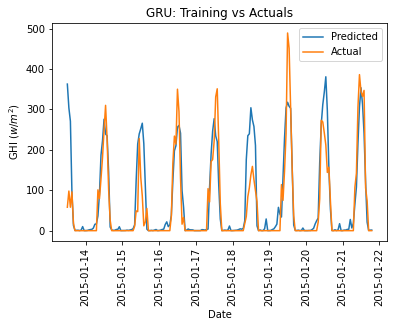

In [50]:
plt.plot(train_results['Train prediction'][300:500], label = 'Predicted')
plt.plot(train_results['Actual'][300:500], label = 'Actual')
plt.xlabel('Date')
plt.ylabel('GHI ($w/m^2$)')
plt.title('GRU: Training vs Actuals')
_=plt.xticks(rotation = 90)
plt.legend()

#### Comparision between Actual and Test predictions - GRU

In [51]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data = {'Test prediction':test_predictions,'Actual':Y_test },index = MEDford_df_new.index[26292:])
test_results

Test prediction  Actual
DateTime                                    
2018-01-01 12:00:00       281.491943   167.0
2018-01-01 13:00:00       200.164093   175.0
2018-01-01 14:00:00       212.034851   151.0
2018-01-01 15:00:00        99.656441    73.0
2018-01-01 16:00:00        35.090881    13.0
...                              ...     ...
2018-12-31 19:00:00         0.872319     0.0
2018-12-31 20:00:00         1.571061     0.0
2018-12-31 21:00:00         1.436558     0.0
2018-12-31 22:00:00        40.859009     0.0
2018-12-31 23:00:00         0.238464     0.0

[8748 rows x 2 columns]

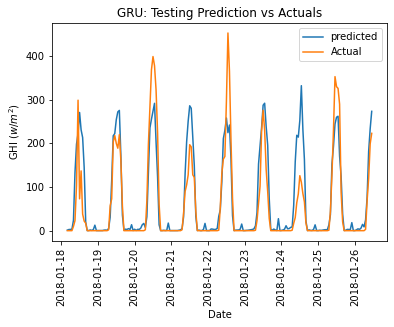

In [52]:
plt.plot(test_results['Test prediction'][400:600],label = 'predicted')
plt.plot(test_results['Actual'][400:600], label = 'Actual')
plt.xlabel('Date')
plt.ylabel('GHI ($w/m^2$)')
plt.title('GRU: Testing Prediction vs Actuals')
_=plt.xticks(rotation = 90)
plt.legend()

In [53]:
from sklearn.metrics import r2_score
print('Training score:', r2_score(Y_train, train_results['Train prediction'] ))
print('Testing score:', r2_score(test_results['Actual'], test_results['Test prediction']))


Training score: 0.9061398377876699
Testing score: 0.8999168168837548


## Scenario 2

##### Winter: 12 ,1 ,2 
##### Spring: 3,4,5
##### Summer: 6,7,8
##### Fall : 9,10,11

In [54]:
Fall_GRU = test_results['2018-9-1 01:00:00': '2018-11-30 23:00:00']
Spring_GRU =test_results['2018-3-1 01:00:00': '2018-5-31 23:00:00']
Summer_GRU = test_results['2018-6-1 01:00:00': '2018-8-31 23:00:00']
W = test_results['2018-1-1 01:00:00': '2018-2-28 23:00:00']
W.values.tolist()
Winter_GRU = W.append(test_results['2018-12-1 01:00:00': '2018-12-31 23:00:00'])
Winter_GRU

Test prediction  Actual
DateTime                                    
2018-01-01 12:00:00       281.491943   167.0
2018-01-01 13:00:00       200.164093   175.0
2018-01-01 14:00:00       212.034851   151.0
2018-01-01 15:00:00        99.656441    73.0
2018-01-01 16:00:00        35.090881    13.0
...                              ...     ...
2018-12-31 19:00:00         0.872319     0.0
2018-12-31 20:00:00         1.571061     0.0
2018-12-31 21:00:00         1.436558     0.0
2018-12-31 22:00:00        40.859009     0.0
2018-12-31 23:00:00         0.238464     0.0

[2147 rows x 2 columns]

In [55]:
%store Fall_GRU
%store Spring_GRU
%store Summer_GRU
%store Winter_GRU

Stored 'Fall_GRU' (DataFrame)
Stored 'Spring_GRU' (DataFrame)
Stored 'Summer_GRU' (DataFrame)
Stored 'Winter_GRU' (DataFrame)


#### Winter

LSTM Winter Testing score: 0.7370090985171578


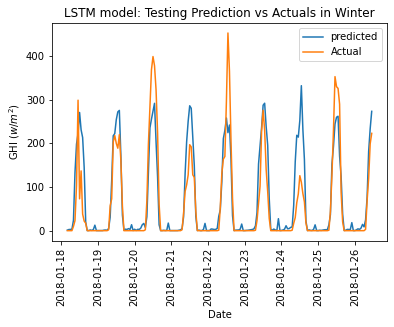

In [56]:
plt.plot(Winter_GRU['Test prediction'][400:600],label = 'predicted')
plt.plot(Winter_GRU['Actual'][400:600], label = 'Actual')
plt.xlabel('Date')
plt.ylabel('GHI ($w/m^2$)')
plt.title('LSTM model: Testing Prediction vs Actuals in Winter')
_=plt.xticks(rotation = 90)
plt.legend()
print('LSTM Winter Testing score:', r2_score(Winter_GRU['Actual'], Winter_GRU['Test prediction']))

#### Summer

LSTM Summer Testing score: 0.9579775617570084


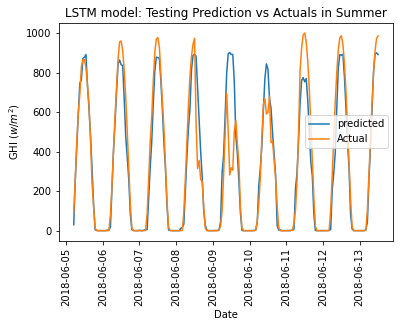

In [57]:
plt.plot(Summer_GRU['Test prediction'][100:300],label = 'predicted')
plt.plot(Summer_GRU['Actual'][100:300], label = 'Actual')
plt.xlabel('Date')
plt.ylabel('GHI ($w/m^2$)')
plt.title('LSTM model: Testing Prediction vs Actuals in Summer')
_=plt.xticks(rotation = 90)
plt.legend()
print('LSTM Summer Testing score:', r2_score(Summer_GRU['Actual'], Summer_GRU['Test prediction']))

#### Spring

LSTM Spring Testing score: 0.8110061310417158


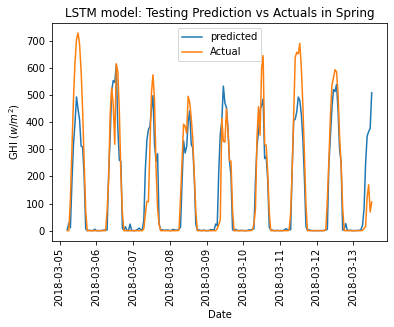

In [58]:
plt.plot(Spring_GRU['Test prediction'][100:300],label = 'predicted')
plt.plot(Spring_GRU['Actual'][100:300], label = 'Actual')
plt.xlabel('Date')
plt.ylabel('GHI ($w/m^2$)')
plt.title('LSTM model: Testing Prediction vs Actuals in Spring')
_=plt.xticks(rotation = 90)
plt.legend()
print('LSTM Spring Testing score:', r2_score(Spring_GRU['Actual'], Spring_GRU['Test prediction']))

#### Fall

LSTM Fall Testing score: 0.9014655059608392


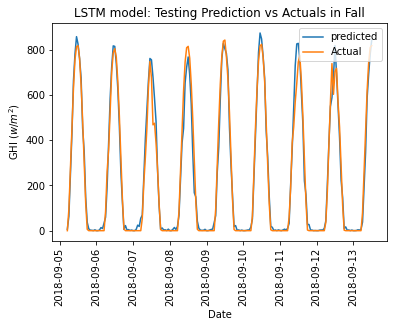

In [59]:
plt.plot(Fall_GRU['Test prediction'][100:300],label = 'predicted')
plt.plot(Fall_GRU['Actual'][100:300], label = 'Actual')
plt.xlabel('Date')
plt.ylabel('GHI ($w/m^2$)')
plt.title('LSTM model: Testing Prediction vs Actuals in Fall')
_=plt.xticks(rotation = 90)
plt.legend()
print('LSTM Fall Testing score:', r2_score(Fall_GRU['Actual'], Fall_GRU['Test prediction']))